In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
import matplotlib.pyplot as plt
import imgaug as ia
import numpy as np
from imgaug import augmenters as iaa

DATASET_PATH = '../segmentation_data'

2022-11-05 22:49:46.972597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 22:49:47.121048: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-05 22:49:47.778355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:
2022-11-05 22:49:47.778428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
images, labels = [], []

In [3]:
for file in os.listdir(DATASET_PATH):
    if file.find('.label.') == -1:
        image_name, ext = os.path.splitext(file)
        label_path = image_name + '.label' + ext
        image = np.array(Image.open(os.path.join(DATASET_PATH, file)))
        label = np.array(Image.open(os.path.join(DATASET_PATH, label_path)))
        
        images.append(image)
        labels.append(label)

In [4]:
n_total = len(images)
n_train = int(0.8*n_total)

print(n_train, "/", n_total)

75 / 94


In [5]:
images_train = images[:n_train]
labels_train = labels[:n_train]
images_val = images[n_train:]
labels_val = labels[n_train:]

resizer = iaa.Resize({"height": 512, "width": 512})

images_val = [resizer.augment(image=img) for img in images_val] 
labels_val = [resizer.augment(image=lab) for lab in labels_val] 

In [6]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

aug_pipeline = iaa.Sequential([
        iaa.Resize({"height": 512, "width": 512}),
        iaa.Sometimes(0.5, iaa.GaussianBlur((0, 3.0))),
        iaa.Sometimes(0.8, iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),
        iaa.SomeOf(
            (2, 5),
            [
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                iaa.Fliplr(1.0),
                iaa.Flipud(1.0),
                iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0.25))),
                iaa.Sometimes(0.5, iaa.Affine(rotate=5)),
            ]
        ),
        iaa.Sometimes(0.5, iaa.ElasticTransformation(alpha=90, sigma=9)),
        iaa.Sometimes(0.4, iaa.Affine(rotate=(-20, 20)))
    ], random_order=True 
)

In [7]:
aug_img, aug_mask = aug_pipeline(image=images_train[0], segmentation_maps=SegmentationMapsOnImage(labels_train[0], shape=images_train[0].shape))

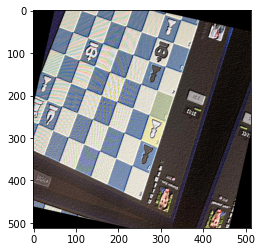

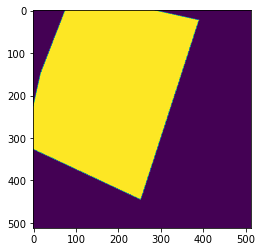

In [8]:
plt.imshow(aug_img)
plt.show()

plt.imshow(aug_mask.get_arr())
plt.show()

In [9]:
n_aug_per_image = 20

In [10]:
train_full_img = []
train_full_label = []

for _ in range(n_aug_per_image):
    for train_img, train_lab in zip(images_train, labels_train):
        aug_img, aug_mask = aug_pipeline(image=train_img, segmentation_maps=SegmentationMapsOnImage(train_lab, shape=train_img.shape))
        train_full_img.append(aug_img)
        train_full_label.append(aug_mask.get_arr())

In [11]:
len(train_full_img)

1500

In [12]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = keras.layers.BatchNormalization()(x)
    # Conv2D then ReLU activation
    x = keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = keras.layers.BatchNormalization()(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = keras.layers.MaxPool2D(2)(f)
    p = keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    # concatenate
    x = keras.layers.concatenate([x, conv_features])
    # dropout
    x = keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_simple_unet():
    # inputs
    inputs = keras.layers.Input(shape=(512,512,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [13]:
def make_conv_block(n_filters, kernel_size=3):
    return keras.models.Sequential([
        keras.layers.MaxPooling2D(2, strides=2, padding="valid"),
        keras.layers.Conv2D(
            kernel_size=(kernel_size,kernel_size),
            filters=n_filters,
            strides=1,
            activation=None,
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation='relu'),
        keras.layers.Conv2D(
            kernel_size=(kernel_size,kernel_size),
            filters=n_filters,
            strides=1,
            activation=None,
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation='relu')
    ])
    
def make_bn_conv(n_filters, kernel_size=3):
    return keras.models.Sequential([
        keras.layers.Conv2D(
            kernel_size=(kernel_size,kernel_size),
            filters=n_filters,
            strides=1,
            activation=None,
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation='relu')
    ])
    
def make_bn_conv_t(n_filters, kernel_size=3):
    return keras.models.Sequential([
        keras.layers.Conv2DTranspose(
            kernel_size=(kernel_size,kernel_size),
            filters=n_filters,
            strides=1,
            activation=None,
            padding='same'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation='relu')
    ])

def build_segmentation_model():
    tf.compat.v1.reset_default_graph()
    entry = keras.layers.Input(shape=(512, 512, 3), name='image_input')
    
    encoder = keras.applications.MobileNetV3Large(
        input_tensor=entry,
        include_top=False,
        alpha=0.75,
        weights='imagenet'
    )
    
    encoder_out = encoder.output

    encoder_to_8 = make_conv_block(256, kernel_size=1)(encoder_out)
    encoder_to_4 = make_conv_block(512, kernel_size=1)(encoder_to_8)
    
    x = encoder_to_4
    for _ in range(2):
        x = make_bn_conv(512, kernel_size=1)(x)
    
    for nf, skip in zip([256], [encoder_to_8]):
        x = keras.layers.Conv2DTranspose(
            filters=nf, kernel_size=1, padding='same', strides=2
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Concatenate()([x, skip])
        x = make_bn_conv_t(nf)(x)
        x = make_bn_conv_t(nf)(x)
    
    skip_outputs_mobilenet = [
        'rescaling', # 512 x 512
        're_lu_2', # 256 x 256
        're_lu_6', # 128 x 128
        'multiply_1', # 64 x 64
        'multiply_13', # 32 x 32
        'multiply_19', # 16 x 16
    ]

    
    for skip_encoder in reversed(skip_outputs_mobilenet):
        skip_layer = encoder.get_layer(skip_encoder)
        skip_filters = skip_layer.output.shape[-1]
        if skip_encoder == skip_outputs_mobilenet[0]:
            skip_filters = 64 # Override filters for last layer
        skip_output = skip_layer.output
        
        kernel_size = 3
        if skip_filters >= 256:
            kernel_size=1
        
        x = keras.layers.Conv2DTranspose(
            filters=skip_filters // 2, kernel_size=kernel_size, padding='same', strides=2
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Concatenate()([x, skip_output])
        x = make_bn_conv(skip_filters // 2, kernel_size=kernel_size)(x)
        x = make_bn_conv(skip_filters // 2, kernel_size=kernel_size)(x)
    x = keras.layers.Conv2D(
        kernel_size=(3, 3),
        filters=1,
        strides=1,
        padding='same',
        activation='sigmoid'
    )(x)
    return keras.models.Model(inputs=[entry], outputs=[x]), encoder

In [14]:
full_model, encoder = build_segmentation_model()
full_model.count_params()

2022-11-05 22:56:45.923741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 22:56:45.949589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 22:56:45.949783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 22:56:45.950202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

6603629

In [15]:
encoder.trainable=False

In [16]:
# It is fine to store the images in the memory as long as it is RAM, not VRAM.

def train_generator():
    for image, label in zip(train_full_img, train_full_label):
        yield image.astype(np.float32)/255, label.astype(np.float32)/255
        
def val_generator():
    for image, label in zip(images_val, labels_val):
        yield image.astype(np.float32)/255, label.astype(np.float32)/255

In [25]:
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((512, 512, 3), (512, 512))
).batch(5)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((512, 512, 3), (512, 512))
).prefetch(16).batch(2)

In [18]:
full_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.MeanIoU(num_classes=2)],
    optimizer=keras.optimizers.Adam(learning_rate=3e-5)
)

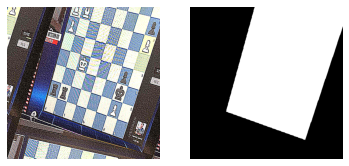

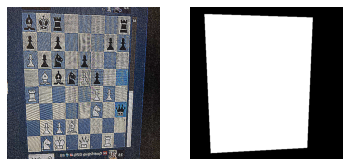

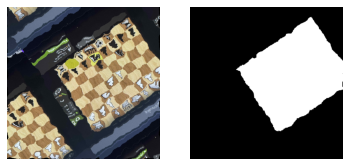

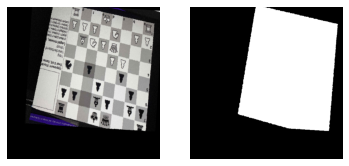

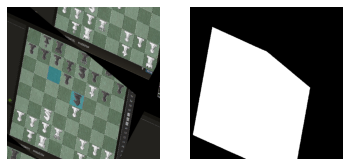

In [19]:
for (inp, lab) in train_dataset.take(5):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.squeeze(inp[0, ...]))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(lab[0, ...]), plt.cm.gray)
    plt.axis("off")
    plt.show()

In [20]:
full_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=400,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
        keras.callbacks.TensorBoard(log_dir='no_finetuning_logs')
    ]
)

Epoch 1/400


2022-11-05 22:56:55.207397: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-05 22:56:55.732766: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


250/250 [==============================] - 58s 196ms/step - loss: 0.4243 - mean_io_u: 0.2527 - val_loss: 0.6988 - val_mean_io_u: 0.2058
Epoch 2/400
250/250 [==============================] - 47s 188ms/step - loss: 0.2612 - mean_io_u: 0.2527 - val_loss: 0.1809 - val_mean_io_u: 0.2058
Epoch 3/400
250/250 [==============================] - 48s 191ms/step - loss: 0.2251 - mean_io_u: 0.2527 - val_loss: 0.1534 - val_mean_io_u: 0.2058
Epoch 4/400
250/250 [==============================] - 47s 188ms/step - loss: 0.1971 - mean_io_u: 0.2527 - val_loss: 0.1503 - val_mean_io_u: 0.2058
Epoch 5/400
250/250 [==============================] - 47s 188ms/step - loss: 0.1724 - mean_io_u: 0.2527 - val_loss: 0.1669 - val_mean_io_u: 0.2058
Epoch 6/400
250/250 [==============================] - 47s 188ms/step - loss: 0.1500 - mean_io_u: 0.2527 - val_loss: 0.1753 - val_mean_io_u: 0.2058
Epoch 7/400
250/250 [==============================] - 47s 188ms/step - loss: 0.1294 - mean_io_u: 0.2527 - val_loss: 0.1558 

250/250 [==============================] - 47s 189ms/step - loss: 0.0292 - mean_io_u: 0.2546 - val_loss: 0.1027 - val_mean_io_u: 0.2065
Epoch 57/400
250/250 [==============================] - 47s 189ms/step - loss: 0.0284 - mean_io_u: 0.2549 - val_loss: 0.1232 - val_mean_io_u: 0.2065
Epoch 58/400
250/250 [==============================] - 47s 189ms/step - loss: 0.0213 - mean_io_u: 0.2540 - val_loss: 0.0993 - val_mean_io_u: 0.2058


In [21]:
full_model.save("model_no_ft.h5")

1/1 [==============================] - 1s 1s/step


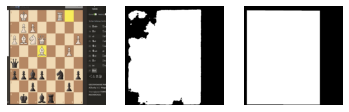

1/1 [==============================] - 0s 30ms/step


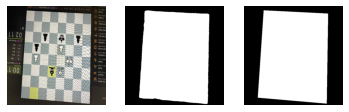

1/1 [==============================] - 0s 29ms/step


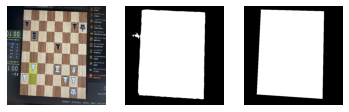

1/1 [==============================] - 0s 28ms/step


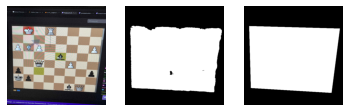

1/1 [==============================] - 0s 36ms/step


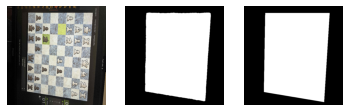

1/1 [==============================] - 0s 34ms/step


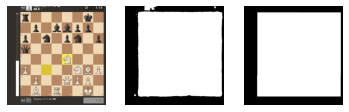

1/1 [==============================] - 0s 35ms/step


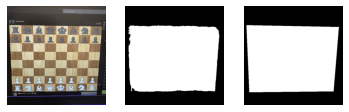

1/1 [==============================] - 0s 26ms/step


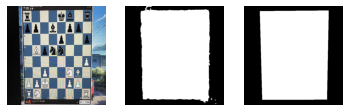

1/1 [==============================] - 0s 29ms/step


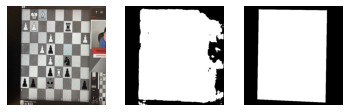

1/1 [==============================] - 0s 35ms/step


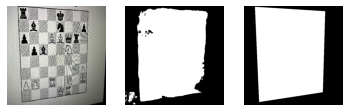

In [22]:
for img_batch, lab_batch in val_dataset.take(15):
    train_img = img_batch[0,...]
    train_lab = lab_batch[0,...]
    pred = full_model.predict(tf.expand_dims(train_img, axis=0))
    pred[pred > .5] = 1
    pred[pred <= .5] = 0
    plt.subplot(1, 3, 1)
    plt.imshow(train_img)
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(pred), plt.cm.gray)
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(train_lab), plt.cm.gray)
    plt.axis("off")
    plt.show()

### The following sections await until enough data is gathered that mobilenet is usable as an encoder

In [23]:
encoder.trainable=True
full_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.MeanIoU(num_classes=2)],
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

In [29]:
full_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=40, restore_best_weights=True),
        keras.callbacks.TensorBoard(log_dir='finetuned_logs')
    ]
)

Epoch 1/500
300/300 [==============================] - 63s 210ms/step - loss: 0.0051 - mean_io_u_1: 0.3120 - val_loss: 0.0244 - val_mean_io_u_1: 0.2285
Epoch 2/500
300/300 [==============================] - 63s 209ms/step - loss: 0.0048 - mean_io_u_1: 0.3216 - val_loss: 0.0253 - val_mean_io_u_1: 0.2428
Epoch 3/500
300/300 [==============================] - 63s 209ms/step - loss: 0.0049 - mean_io_u_1: 0.3370 - val_loss: 0.0300 - val_mean_io_u_1: 0.2336
Epoch 4/500
300/300 [==============================] - 63s 209ms/step - loss: 0.0050 - mean_io_u_1: 0.3533 - val_loss: 0.0269 - val_mean_io_u_1: 0.2674
Epoch 5/500
300/300 [==============================] - 63s 209ms/step - loss: 0.0051 - mean_io_u_1: 0.3635 - val_loss: 0.0342 - val_mean_io_u_1: 0.2293
Epoch 6/500
300/300 [==============================] - 63s 209ms/step - loss: 0.0052 - mean_io_u_1: 0.3692 - val_loss: 0.0383 - val_mean_io_u_1: 0.2234
Epoch 7/500
300/300 [==============================] - 63s 210ms/step - loss: 0.0052 - m

In [30]:
full_model.save("finetuned_model2.h5")

1/1 [==============================] - 0s 33ms/step


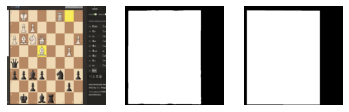

1/1 [==============================] - 0s 37ms/step


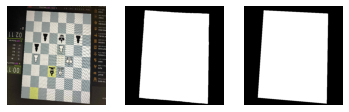

1/1 [==============================] - 0s 38ms/step


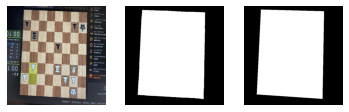

1/1 [==============================] - 0s 29ms/step


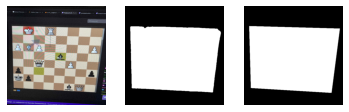

1/1 [==============================] - 0s 33ms/step


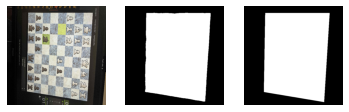

1/1 [==============================] - 0s 38ms/step


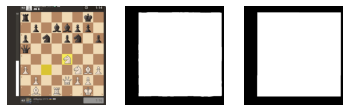

1/1 [==============================] - 0s 37ms/step


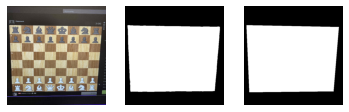

1/1 [==============================] - 0s 26ms/step


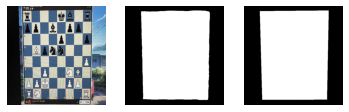

1/1 [==============================] - 0s 36ms/step


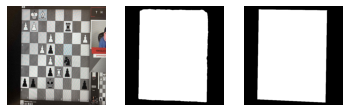

1/1 [==============================] - 0s 26ms/step


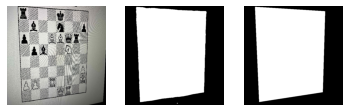

In [31]:
for img_batch, lab_batch in val_dataset:
    train_img = img_batch[0,...]
    train_lab = lab_batch[0,...]
    pred = full_model.predict(tf.expand_dims(train_img, axis=0))
    pred[pred > .5] = 1
    pred[pred <= .5] = 0
    plt.subplot(1, 3, 1)
    plt.imshow(train_img)
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(pred), plt.cm.gray)
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(train_lab), plt.cm.gray)
    plt.axis("off")
    plt.show()